In [1]:
import sys
import os

notebook_dir = os.path.abspath('')
sys.path.append(os.path.join(notebook_dir, 'WildfirePredict'))

# Import necessary libraries
import numpy as np
import random

import torch
from torch.utils.data import DataLoader, random_split
from WildfirePredict.dataset import WildfireDataset
from WildfirePredict.model import ConvLSTMModel
from WildfirePredict.training import WildfireTrainer
from WildfirePredict.predict import WildfirePredictor
from WildfirePredict.utils import plot_sequences

from sklearn.metrics import mean_squared_error

## 1 Data and Dataset

In [2]:
train_data_path = "./Ferguson_fire_train.npy"
test_data_path = "./Ferguson_fire_test.npy"

# load the training data and reshape
train_data = np.load(train_data_path)
print(f"Train data shape: {np.shape(train_data)}")

# load the test data and reshape
test_data = np.load(test_data_path)
print(f"Test data shape: {np.shape(test_data)}")

# Reshape data to include channel dimension
train_data_series = train_data.reshape(125, 100, 1, 256, 256).astype(np.float32)
test_data_series = test_data.reshape(50, 100, 1, 256, 256).astype(np.float32)

# Verify the new shape
print(train_data_series.shape)  # Should be (100, 100, 1, 256, 256)
print(test_data_series.shape)   # Should be (50, 100, 1, 256, 256)

Train data shape: (12500, 256, 256)
Test data shape: (5000, 256, 256)
(125, 100, 1, 256, 256)
(50, 100, 1, 256, 256)


In [3]:
window_size = 5
step_size = 5
batch_size = 16

train_dataset = WildfireDataset(train_data_series, window_size, step_size)
test_dataset = WildfireDataset(test_data_series, window_size, step_size)

# Use random_split to divide the dataset
total_size = len(train_dataset)
val_size = int(0.2 * total_size)  # 20% as validation set
train_size = total_size - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Print the sizes of the split datasets
print(f'Training dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Training dataset size: 2000
Validation dataset size: 500
Test dataset size: 1000


## 2 Model

In [6]:
# Model parameters
input_dim = 1
hidden_dim = [64, 64]
kernel_size = (3, 3)
num_layers = 2
output_dim = 1

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the model
model = ConvLSTMModel(input_dim, hidden_dim, kernel_size, num_layers, output_dim)
model.to(device)

ConvLSTMModel(
  (convlstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(65, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): ConvLSTMCell(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (conv): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
)

In [ ]:
# If trained model is going to be employed, run this block
!curl "https://drive.usercontent.google.com/download?id={1-5JDB_1fgrzBB2PJpCEbEHV9jBqwDm7a}&confirm=xxx" -o "trained_model.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('trained_model.pth'))
model.to(device)

## 3 Train the model

In [ ]:
# Parameters
num_epochs = 20
learning_rate = 0.001

# Loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Create the trainer
trainer = WildfireTrainer(model, train_loader, val_loader, test_loader, device, criterion, optimizer, num_epochs)

# Train the model
trainer.train()

# Test the model
trainer.test()

## 4 Prediction

In [4]:
data_path = "Ferguson_fire_"

# load the background data and reshape
background_data = np.load(data_path + "background.npy")
print(f"Background data shape: {np.shape(background_data)}")

# load the observation data and reshape
obs_data = np.load(data_path + "obs.npy")
print(f"observation data shape: {np.shape(obs_data)}")

Background data shape: (5, 256, 256)
observation data shape: (5, 256, 256)


In [8]:
# Convert background_data to tensor and add batch and sequence dimensions
background_input = background_data[:4]
background_output = background_data[4]
background_input_tensor = torch.tensor(background_input.astype(np.float32)).unsqueeze(0).unsqueeze(2).to(device)

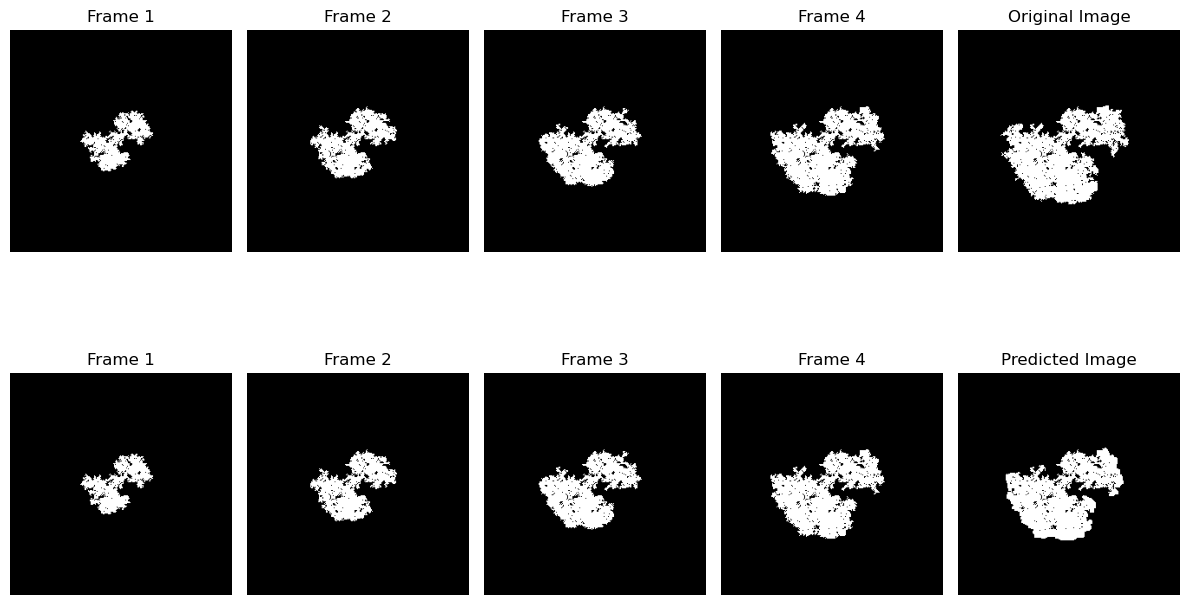

MSE of background data:  0.02192688


In [10]:
# Create the predictor
predictor = WildfirePredictor(model, device)

predicted_output = predictor.predict_image(background_input_tensor)
plot_sequences(background_input, background_output, predicted_output)

background_mse = mean_squared_error(background_output, predicted_output)
print('MSE of background data: ', background_mse)